# Machine Learning with Phenotypic Data

This notebook investigates the performance of machine learning models to recognize ADHD in subjects. 
This dataset consists of the pheyotypic data from the 7 training sites from the ADHD-200 Compeition set.

The features for this analysis contains the personal characteristics for each subject

This notebook runs six tests to evaluate the accuracy of multiple classification models.
1. Multi-class diagnosis (uses all diagnosis types)
1. Multi-class diagnosis (uses all diagnosis types) with scaled features
1. Multi-class diagnosis (uses all diagnosis types) with normalized features
2. Binary classification (if subject has ADHD or not)
2. Binary classification (if subject has ADHD or not) with scaled features
2. Binary classification (if subject has ADHD or not) with normalized features

## Imports

These are the imports that are required for this notebook to run properly

- `os` to access the file

- `pandas` to work with dataframes

- `numpy` for linear algebra

- `seaborn` for customizable plotting

- `matplotlib.pyplot` for plotting


- `train_test_split()` for splitting data into a training and testing set

- `LogisticRegression` for a logistic regression machine learning model

- `KNeighborsClassifier` for a KNN machine learning model

- `SVC` for a SVM machine learning model

- `LinearDiscriminantAnalysis` for a LDA machine learning model

- `Voting Classifier` for ensemble methods


- `accuracy_score()` to evaluate the accuracy of the model

- `confusion_matrix` and `ConfusionMatrixDisplay` for viewing confusion matrices

- `StratifiedKFold, cross_valscore()` for cross validation

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler

In [2]:
models = []

logr = LogisticRegression()
knn = KNeighborsClassifier()
svm = SVC()
lda = LinearDiscriminantAnalysis()
ens = VotingClassifier([('logr',logr), ('knn',knn), ('svm',svm), ('lda',lda)])
ensl = VotingClassifier([('logr',logr), ('knn',knn), ('svm',svm)])

models.append(('LR', logr))
models.append(('KNN', knn))
models.append(('SVM', svm))
models.append(('LDA', lda))
models.append(('Ensemble', ens))
models.append(('Ensemble Less', ensl))

## Functions

There are several functions in this notebook to improve the code readability and reduce the length of the code

### get_base_filepath()

Access the filepath for th ebase folder of the project. 
From here, any other asset of the project can be located.

In [3]:
def get_base_filepath():
    '''
    Access the filepath for the base folder of the project
    
    Input: None
    
    Output: The filepath to the root of the folder
    '''
    # Get current directory
    os.path.abspath(os.curdir)

    # Go up a directory level
    os.chdir('..')
    os.chdir('..')

    # Set baseline filepath to the project folder directory
    base_folder_filepath = os.path.abspath(os.curdir)
    return base_folder_filepath

### normalize()

Normalizes a Series

**Input:** A feature of type Series

**Output:** The normalized feature of type Series

In [4]:
def normalize(feature):
    '''
    This function normalizes a Series
    
    Input: A feature of type Series
    
    Output: The normalized feature of type Series
    '''
    return (feature - feature.mean())/feature.std()

### normalize_features()

Normalizes all features in a given dataframe. This will normalize ALL features, so ensure that the inputted dataframe consists only of numeric values.

**Input:** A dataframe to normalize

**Output:** A normalized dataframe

In [5]:
def normalize_features(df):
    '''
    This function normalizes all features in a dataframe
    
    Input: A pandas dataframe
    
    Output: The normalized dataframe
    '''
    for column in df.columns:
        df[column] = normalize(df[column])
    return df

### get_statistics()

Get the descriptive statistics for a list of values
    
**Input:** A list of accuracies
    
**Output:** The mean, std, max, and min for each model's accuracy

In [6]:
def get_statistics(accuracy_list):
    '''
    Get the descriptive statistics for a list of values
    
    Input: A list of accuracies
    
    Output: The mean, std, max, and min for each model's accuracy
    '''
    # Create empty lists for descriptive statistics
    means = []
    stds = []
    maxes = []
    mins = []
    
    # Access the descriptive statistics for each list of accuracies
    for accuracy in accuracy_list:
        accuracy_np = np.array(accuracy)
        means.append(accuracy_np.mean())
        stds.append(accuracy_np.std())
        maxes.append(accuracy_np.max())
        mins.append(accuracy_np.min())
        
    # Create a list for the statistics
    stats = [means, stds, maxes, mins]
    return stats

### make_predictions()

Fit a model using the training data, 
make predictions on a testing set, 
and get the accuracy of the model.

Used in evaluate_models()

In [7]:
def make_predictions(model, X_trn, X_tst, y_trn, y_tst):
    '''
    Get the accuracy of a model
    
    Input:
        - A model to use to make predictions
        - Set of training features
        - Set of testing features
        - Set of training targets
        - Set of testing targets
        
    Output: 
        - Predictions for models
        - Accuracy of the model
    '''
    
    # Train the model on the training set
    model_fit = model.fit(X_trn, y_trn)
    
    # Make predictions on the testing features
    y_pred = model_fit.predict(X_tst)
    
    # Compare the predictions to the true values
    accuracy = accuracy_score(y_pred, y_tst)
    
    # Return the predictions and accuracy
    return y_pred, accuracy

### evaluate_models()

Evaluate the performance of models on a set of features and targets.

Uses make_predictions()

Used in get_accuracies()

In [8]:
def evaluate_models(X, y):
    '''
    Evaluate the performance of models on a set of features and targets.
    
    Input:
        - Set of features
        - Set of targets
        
    Output: 
        - Confusion matrices for models
        - Accuracy of models
    '''
    # Create empty lists to store values
    predictions = dict()
    accuracies = []
    confusion_matrices = []
    
    # Separate the data into training and testing sets
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y)
    
    # Evaluate the accuracies using each model
    for name, model in models:
        pred, acc = make_predictions(model, X_trn, X_tst, y_trn, y_tst)
        predictions[name] = pred
        accuracies.append(acc)

    # Get the confusion matrix for each set of predictions
    for name, model in models:
        confusion_matrices.append(confusion_matrix(predictions[name], y_tst))
    
    # Return the accuracy and confusion matrices in a list format
    return accuracies, confusion_matrices

### get_accuracies()

Get 100 accuracies for models

In [9]:
def get_accuracies(X, y):
    '''
    Get 100 accuracies for three models (Logistic regression, KNN, SVM).
    
    Input:
        - Set of features
        - Set of targets
        
    Output: 
        - List of 100 accuracies for models
        - LIst of 100 confusion matrices for models
    '''
    # Create an empty list to store the accuracies for each model
    lr_acc = []
    knn_acc = []
    svm_acc = []
    lda_acc = []
    ens_acc = []
    ensl_acc = []
    
    lr_matrices = []
    knn_matrices = []
    svm_matrices = []
    lda_matrices = []
    ens_matrices = []
    ensl_matrices = []
    
    # Run 100 iterations of evaluating the model
    for i in range(100):
        # Get the accuracy for this iteration
        accuracies, cf_matrices = evaluate_models(X, y)
        
        # Add it to the corresponding model holder
        lr_acc.append(accuracies[0])
        knn_acc.append(accuracies[1])
        svm_acc.append(accuracies[2])
        lda_acc.append(accuracies[3])
        ens_acc.append(accuracies[4])
        ensl_acc.append(accuracies[5])
                  
        # Add the confusion matrix to the corresponding model holder
        lr_matrices.append(cf_matrices[0])
        knn_matrices.append(cf_matrices[1])
        svm_matrices.append(cf_matrices[2])
        lda_matrices.append(cf_matrices[3])
        ens_matrices.append(cf_matrices[4])
        ensl_matrices.append(cf_matrices[5])
                   
    # Return a list of all accuracies and confusion matrices
    return [lr_acc, knn_acc, svm_acc, lda_acc, ens_acc, ensl_acc], [lr_matrices, knn_matrices, svm_matrices, lda_matrices, ens_matrices, ensl_matrices]

### perform_cross_validation()

Use a stratified K-fold for cross validation for the three classification models 

In [10]:
def perform_cross_validation(X_train, y_train):
    '''
    Input: 
        - A dataframe containing the features use to build the model
        - A Series of the true values associated with the feature list
    
    Output: Printed result for the mean and standard deviation of each model
    '''
    # Create an empty dictionary to store the results
    results = dict()

    # Loop through the models
    for name, model in models:
        # Create a Stratified K-fold for cross validation
        kfold = StratifiedKFold(n_splits=10)
        
        # Apply cross validation using the current model
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
        
        # Add the mean and standard deviation to the dictionary
        results[name] = (cv_results.mean(), cv_results.std())

    # Print the results
    print('Model\t\tCV Mean\t\tCV std')
    print(results)

### get_avg_cfm()

Get the average confusion matrix for a list of 100 matrices
    
**Input:** a list of 100 confusion matrices
    
**Output:** the average confusion matrix

In [11]:
def get_avg_cfm(cfms):
    '''
    Get the average confusion matrix for a list of 100 matrices
    
    Input: a list of 100 confusion matrices
    
    Output: the average confusion matrix
    '''
    # Create an empty confusion matrix based on the size
    if len(cfms[0]) == 2:
        cfm = [[0,0],
                [0,0]]
    else:
        cfm = [[0,0,0,0],
               [0,0,0,0],
               [0,0,0,0],
               [0,0,0,0]]
          
            
    # Sum up the values for each index in the confusion matrix
    for matrix in cfms:
        for row in range(len(matrix)):
            for col in range(len(matrix[row])):
                # If the row or column are out of bounds, skip it and move on
                if (len(matrix)==3 and len(cfm)==4) and (col==3 or row==3):
                    continue
                    
                # If the row or column is at diagnosis 2 and the matrix is the incorrect size, move on
                elif (len(matrix)==3 and len(cfm)==4) and (col==2 or row==2):
                    continue
                    
                # Otherwise, add the element to the sum matrix
                cfm[row][col] += matrix[col][row]
                
                
    # Divide by the number of values in the set
    for row in range(len(cfm)):
        for col in range(len(cfm[row])):
            cfm[row][col] /=100       
    
    # Return the mean confusion matrix
    return cfm

### get_model_cfms()

Get the confusion matrix for each model; intended for use after 100-iteration train/test split
    
**Input:** A list of the confusion matrices for each model
    
**Output:** The average confusion matrix for each model

In [12]:
def get_model_cfms(cfms):
    '''
    Get the confusion matrix for each model; intended for use after 100-iteration train/test split
    
    Input: A list of the confusion matrices for each model
    
    Output: The average confusion matrix for each model
    '''
    # Create an empty list to store the average confusion matrices in
    model_cfms = []
    
    # Get the average cfm for each model type
    for cfm_set in cfms:
        model_cfms.append(get_avg_cfm(cfm_set))
    
    # Return the average confusion matrices for each model type
    return model_cfms

### print_confusion_matrix()

Print a confusion matrix

**Input:**

- Confusion matrix to print
- A string to make a more clear title for the graph
        
**Ouput:** Display the confusion matrix

In [13]:
def print_confusion_matrix(cmf, name):
    '''
    Print a confusion matrix
    
    Input:
        - Confusion matrix to print
        - A string to make a more clear title for the graph
        
    Ouput: Display the confusion matrix
    '''
    # Create matrix part of heatmape
    sns.heatmap(cmf,
            annot=True,
        )
    
    # Make graph labels
    plt.ylabel('Actual')
    plt.xlabel('Prediction')
    plt.title('Confusion Matrix for ' + name)
        
    # Display graph
    plt.show()

### print_model_cfms()

Print all model confusion matrices 
    
**Input:** A list of confusion matrices for each model
    
**Output:** Average confusion matrix for each model printed

In [14]:
def print_model_cfms(cfms):
    '''
    Print all model confusion matrices 
    
    Input: A list of confusion matrices for each model
    
    Output: Average confusion matrix for each model printed
    '''
    for i, (name, model) in enumerate(models):
        plt.figure(figsize=(3,2))
        print_confusion_matrix(get_model_cfms(cfms)[i], name)

## Import File

Locate the file using its filepath from the base folder and load the file as a dataframe.

In [15]:
# The folder for the project
base_folder_filepath = get_base_filepath()

# Phenotypic data site folder
filepath = base_folder_filepath + '\\Data\\Phenotypic\\2023.7.11-Cleaned_Phenotypic_Training_Sites.csv'

# Dataframe from filepath
df_pheno = pd.read_csv(filepath, index_col='ID')

--------------------------------------------------------------------------------------------------------------------------------

# Multi-Class Classificaiton

This section investigates how models perform when predicting the type of ADHD the subject has or if they are a control.

This is accomplished by using the phenotypic data for the sites. The target will be the diagnosis which includes three types with each number corresponding to a type diagnosis for ADHD.

    0 = TDC (Typically developing children)
    1 = ADHD-Combined
    2 = ADHD-Hyperactive/Impulsive
    3 = ADHD-Inattentive
    
There will be three methods to make these predictions: 

- Current dataframe

- Scaled dataframe

- Normalized dataframe

## Current Dataframe

This model will use the current dataframe without any modifications to the features. 
This will act as a baseline to compare the models with changes to.

### Separate data

Split the data into features and target.

In [16]:
X = df_pheno.drop('DX', axis=1)
y = df_pheno['DX']

### Evaluate Accuracy

Determine the accuracy of using this dataframe. 

#### 100-iteration Train/Test Split

Do 100-iterations of train/test splits using this dataframe. 
Generate 100 accuracies for the four models.

In [17]:
accs, cfms = get_accuracies(X, y)

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

#### View Confusion Matrices

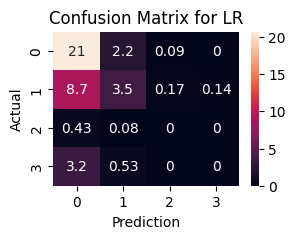

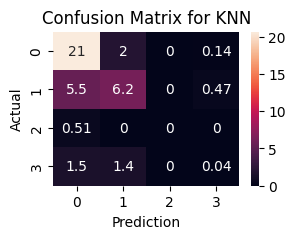

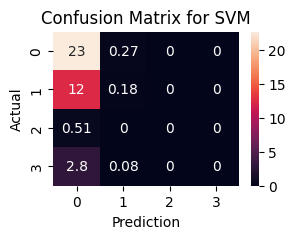

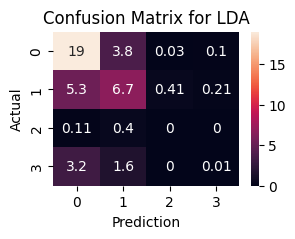

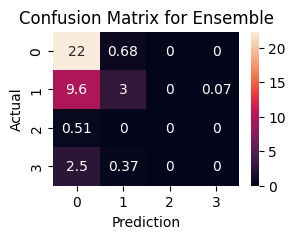

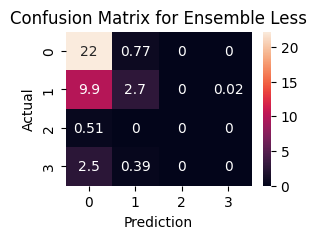

In [18]:
print_model_cfms(cfms)

Extract descriptive statistics from the accuracies.

In [19]:
stats = get_statistics(accs)
results = pd.DataFrame(stats, 
                       index=['Mean', 'STD', 'Max', 'Min'], 
                       columns=['LR_multiclass', 'KNN_multiclass', 
                                'SVM_multiclass', 'LDA_multiclass', 
                                'Ensemble_multiclass', 'Ensemble2_multiclass'])

results

,LR_multiclass,KNN_multiclass,SVM_multiclass,LDA_multiclass,Ensemble_multiclass,Ensemble2_multiclass
Mean,0.563953,0.626977,0.532326,0.598372,0.588837,0.580000
STD,0.067752,0.056481,0.059826,0.061692,0.068190,0.067066
Max,0.767442,0.744186,0.674419,0.720930,0.720930,0.720930
Min,0.372093,0.441860,0.348837,0.395349,0.395349,0.395349


#### Cross-validation

Perform cross validation on this dataset with the four models from before. This is done to compare the results to the train-test split method.

In [20]:
perform_cross_validation(X, y)

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the num

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Model		CV Mean		CV std
{'LR': (0.6202614379084967, 0.07746959319662121), 'KNN': (0.6323529411764707, 0.09776923610938038), 'SVM': (0.5499999999999999, 0.041698373172817146), 'LDA': (0.5908496732026143, 0.10405097381507136), 'Ensemble': (0.6202614379084967, 0.0898758167558105), 'Ensemble Less': (0.6143790849673203, 0.06262242910851497)}


C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

### Method Conclusion

KNN was the most accurate method in both the train/test split and cross-validation with similar scores for both. The cross-validation evaluated logistic regression much higher than the train/test split. 

## Scaled Dataframe

This model will use a scaled version of the dataframe. 
This method will scale all of the features to be within 0 and 1. 

This should reduce some of the bias that results from the different scales in the dataframe's features

### Separate data

Make a copy of the original dataframe to ensure that it is preserved. 
Split the data into features and target.

In [21]:
df_pheno_scaled = df_pheno.copy()

X_scaled = df_pheno_scaled.drop('DX', axis=1)
y_scaled = df_pheno_scaled['DX']

### Transform columns

Apply the scaler to the features and update the feature dataframe to include these changes.

In [22]:
column_transformer = make_column_transformer(
    (MinMaxScaler(), ['Age','Handedness','Verbal IQ','Performance IQ','IQ']),
    remainder='passthrough')

# Apply the transforms to the training data
X_scaled = column_transformer.fit_transform(X_scaled)
X_scaled = pd.DataFrame(data=X_scaled, columns=column_transformer.get_feature_names_out())

### Evaluate Accuracy

Determine the accuracy of using this dataframe. 

#### 100-iteration Train/Test Split

Do 100-iterations of train/test splits using this dataframe. 
Generate 100 accuracies for the four models.

In [23]:
accs_scaled, cfms_scaled = get_accuracies(X_scaled, y)

#### View Confusion Matrices

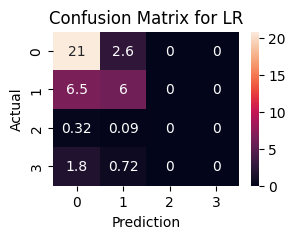

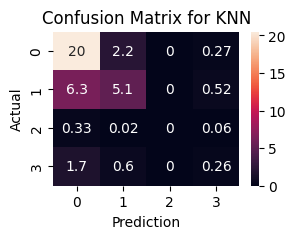

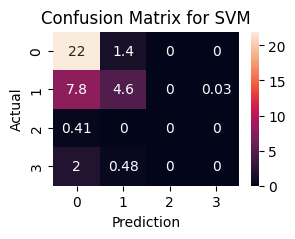

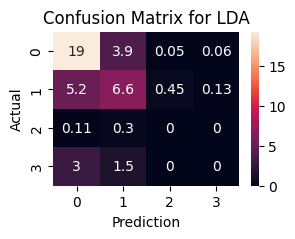

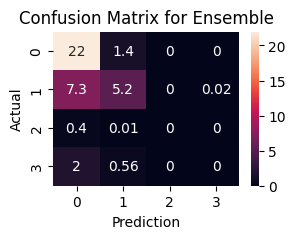

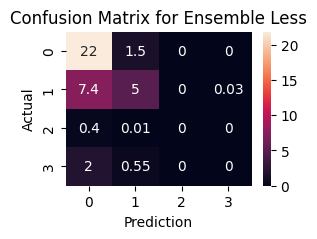

In [24]:
print_model_cfms(cfms_scaled)

Extract descriptive statistics from the accuracies.

In [25]:
stats_scaled = get_statistics(accs_scaled)
results_scaled = pd.DataFrame(stats_scaled, 
                       index=['Mean', 'STD', 'Max', 'Min'], 
                       columns=['LR_multiclass_scaled', 'KNN_multiclass_scaled', 
                                'SVM_multiclass_scaled', 'LDA_multiclass_scaled',
                                'Ensemble_multiclass_scaled', 'Ensemble2_multiclass_scaled'])

results_scaled

,LR_multiclass_scaled,KNN_multiclass_scaled,SVM_multiclass_scaled,LDA_multiclass_scaled,Ensemble_multiclass_scaled,Ensemble2_multiclass_scaled
Mean,0.621860,0.610930,0.617442,0.602791,0.630698,0.625581
STD,0.069115,0.066094,0.062087,0.074104,0.061729,0.062185
Max,0.837209,0.790698,0.790698,0.813953,0.813953,0.813953
Min,0.441860,0.441860,0.488372,0.418605,0.488372,0.488372


#### Cross-validation

Perform cross validation on this dataset with the four models from before. This is done to compare the results to the train-test split method.

In [26]:
perform_cross_validation(X_scaled, y_scaled)

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_sp

Model		CV Mean		CV std
{'LR': (0.596732026143791, 0.07913896498278652), 'KNN': (0.5915032679738561, 0.10996137170831338), 'SVM': (0.6143790849673203, 0.08179079848868318), 'LDA': (0.5908496732026143, 0.10405097381507136), 'Ensemble': (0.6320261437908496, 0.08875662978632372), 'Ensemble Less': (0.6261437908496732, 0.081413880360889)}


### Method Conclusion

The most accurate model for this method is the ensemble of all standard classification methods for train/test split and SVM for cross-validation. 
The the difference between accuracy scores for the different methods was much closer using this dataframe in both evaluation methods. 

None of these models yielded results that were more accurate than using the unchanged dataframe.

## Normalized Dataframe

This model will use a normalized version of the dataframe. 
This method will adjust the features to be normally distributed.

This should reduce some of the bias that results from the different scales in the dataframe's features

### Separate data

Make a copy of the original dataframe to ensure that it is preserved. 
Split the data into features and target.

In [27]:
df_pheno_norm = df_pheno.copy()

X_norm = df_pheno_norm.drop('DX', axis=1)
y_norm = df_pheno_norm['DX']

### Normalize columns

Normalize the features and update the feature dataframe to use these changes.

In [28]:
X_norm = normalize_features(X_norm)

### Evaluate Accuracy

Determine the accuracy of using this dataframe. 

#### 100-iteration Train/Test Split

Do 100-iterations of train/test splits using this dataframe. 
Generate 100 accuracies for the four models.

In [29]:
accs_norm, cfms_norm = get_accuracies(X_norm, y)

#### View Confusion Matrices

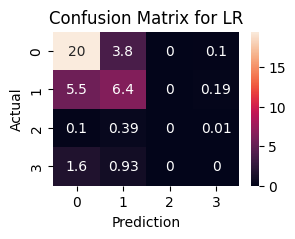

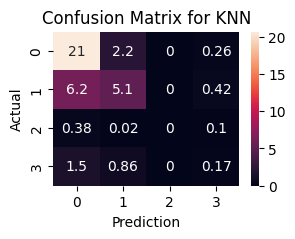

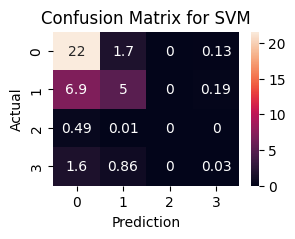

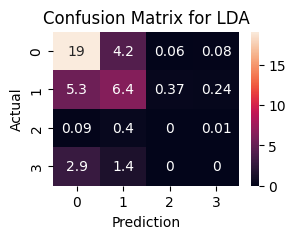

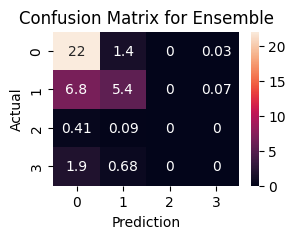

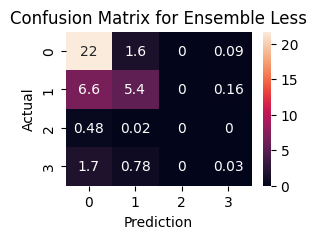

In [30]:
print_model_cfms(cfms_norm)

Extract descriptive statistics from the accuracies.

In [31]:
stats_norm = get_statistics(accs_norm)
results_norm = pd.DataFrame(stats_norm, 
                       index=['Mean', 'STD', 'Max', 'Min'], 
                       columns=['LR_multiclass_norm', 'KNN_multiclass_norm', 
                                'SVM_multiclass_norm', 'LDA_multiclass_norm',
                                'Ensemble_multiclass_norm', 'Ensemble2_multiclass_norm'])

results_norm

,LR_multiclass_norm,KNN_multiclass_norm,SVM_multiclass_norm,LDA_multiclass_norm,Ensemble_multiclass_norm,Ensemble2_multiclass_norm
Mean,0.603023,0.610698,0.619767,0.592791,0.637907,0.630698
STD,0.064554,0.060699,0.062694,0.066878,0.061815,0.062599
Max,0.744186,0.767442,0.837209,0.720930,0.837209,0.837209
Min,0.441860,0.441860,0.465116,0.395349,0.488372,0.441860


#### Cross-validation

Perform cross validation on this dataset with the four models from before. This is done to compare the results to the train-test split method.

In [32]:
perform_cross_validation(X_norm, y_norm)

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_sp

Model		CV Mean		CV std
{'LR': (0.5967320261437907, 0.09860620361317769), 'KNN': (0.6150326797385621, 0.10340232841909969), 'SVM': (0.6147058823529411, 0.08769442068162102), 'LDA': (0.5908496732026143, 0.10405097381507136), 'Ensemble': (0.6379084967320262, 0.07930881731826149), 'Ensemble Less': (0.6320261437908498, 0.08058322583542948)}


### Method Conclusion

The most accurate model for this method is SVM regression for both the train/test split and cross-validation. 
The the difference between accuracy scores for the different methods was much closer using this dataframe in both evaluation methods than the base multi-class models. 

None of these models yielded results that were more accurate than using the unchanged dataframe.

## Classification Conclusion

The most accurate method for this classification method was KNN on the unchanged dataframe.

--------------------------------------------------------------------------------------------------------------------------------

# Binary Classificaiton

This section investigates how models perform when predicting whether a patient has ADHD or not. 

This is accomplished by converting the diagnosis to a binary value based on if their diagnosis is a control or has some type of ADHD. 
For this feature, 'True' signifies the subject has ADHD and 'False' signifies the subject is a control and does not have ADHD.

Theoretically, this model should perform better than the multi-class classification since it is simpler.

## Base Binary Dataframe

The binary dataframe is exactly the same as the multiclass dataframe except the diagnosis is binary. 
Any value for 'DX' greater than 0 for this column indicates that the subject has ADHD.

In [33]:
df_pheno_binary = df_pheno.copy()

df_pheno_binary['DX'].loc[df_pheno_binary['DX'] > 0] = 1
df_pheno_binary.head()

C:\Users\taylo\AppData\Local\Temp\ipykernel_6472\2313971972.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pheno_binary['DX'].loc[df_pheno_binary['DX'] > 0] = 1


,Gender,Age,Handedness,Verbal IQ,Performance IQ,IQ,DX
ID,,,,,,,
1038415,1,14.92,1.0,109.0,103.0,107.0,1
1201251,1,12.33,1.0,115.0,103.0,110.0,1
1245758,0,8.58,1.0,121.0,88.0,106.0,0
1253411,1,8.08,1.0,119.0,106.0,114.0,0
1419103,0,9.92,1.0,124.0,76.0,102.0,0


## Binary Current Dataframe

This model will use the current dataframe with the only modification being to the diagnosis column. 
Any value for 'DX' greater than 0 indicates that the patient has ADHD.

This will act as a baseline to compare the binary models with other changes to.

### Separate data

Split the data into features and target.

In [34]:
X_binary = df_pheno_binary.drop('DX', axis=1)
y_binary = df_pheno_binary['DX']

### Evaluate Accuracy

Determine the accuracy of using this dataframe. 

#### 100-iteration Train/Test Split

Do 100-iterations of train/test splits using this dataframe. 
Generate 100 accuracies for the four models.

In [35]:
accs_binary, cfm_binary = get_accuracies(X_binary, y_binary)

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

#### View Confusion Matrices

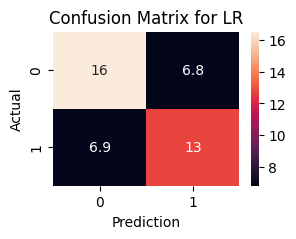

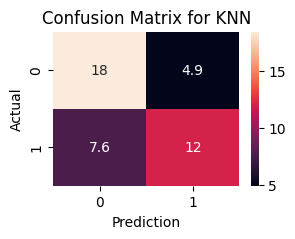

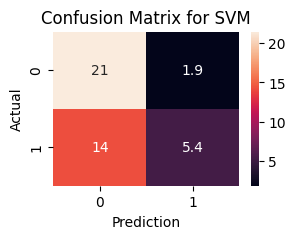

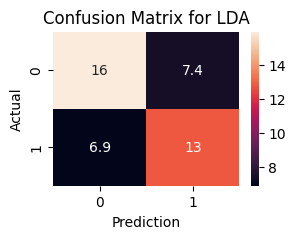

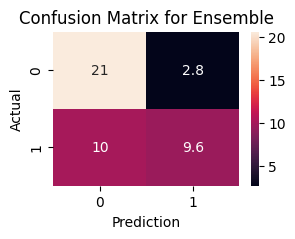

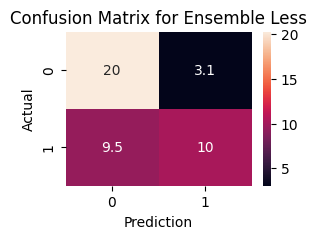

In [36]:
print_model_cfms(cfm_binary)

Extract descriptive statistics from the accuracies.

In [37]:
stats_binary = get_statistics(accs_binary)
results_binary = pd.DataFrame(stats_binary, 
                              index=['Mean', 'STD', 'Max', 'Min'], 
                              columns=['LR_binary', 'KNN_binary', 
                                       'SVM_binary', 'LDA_binary', 
                                       'Ensemble_binary', 'Ensemble2_binary'])

results_binary

,LR_binary,KNN_binary,SVM_binary,LDA_binary,Ensemble_binary,Ensemble2_binary
Mean,0.680000,0.709767,0.624186,0.667907,0.701860,0.708837
STD,0.055534,0.060059,0.075481,0.053648,0.064396,0.066226
Max,0.883721,0.837209,0.790698,0.813953,0.860465,0.860465
Min,0.558140,0.534884,0.395349,0.534884,0.511628,0.511628


#### Cross-validation

Perform cross validation on this dataset with the four models from before. This is done to compare the results to the train-test split method.

In [38]:
perform_cross_validation(X_binary, y_binary)

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Model		CV Mean		CV std
{'LR': (0.6892156862745098, 0.15439542397196646), 'KNN': (0.7019607843137254, 0.11222814134317007), 'SVM': (0.6552287581699345, 0.10875284756333237), 'LDA': (0.654248366013072, 0.14621982892158555), 'Ensemble': (0.7189542483660131, 0.12055236195246585), 'Ensemble Less': (0.7251633986928103, 0.12055634840645918)}


C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Method Conclusion

The most accurate model for this method is KNN regression for both the train/test split and cross-validation. 

The baseline for binary diagnosis is much higher than any of the multi-class dataframe models.

## Scaled Binary Dataframe

This model will use a scaled version of the dataframe. 
This method will scale all of the features to be within 0 and 1. 

This should reduce some of the bias that results from the different scales in the dataframe's features

### Separate data

Make a copy of the original dataframe to ensure that it is preserved. 
Split the data into features and target.

In [39]:
df_pheno_binary_scaled = df_pheno_scaled.copy()

X_binary_scaled = df_pheno_binary_scaled.drop('DX', axis=1)
y_binary_scaled = df_pheno_binary_scaled['DX']

### Transform columns

Apply the scaler to the features and update the feature dataframe to include these changes.

In [40]:
column_transformer = make_column_transformer(
    (MinMaxScaler(), ['Age','Handedness','Verbal IQ','Performance IQ','IQ']),
    remainder='passthrough')

# Apply the transforms to the training data
X_binary_scaled = column_transformer.fit_transform(X_binary_scaled)
X_binary_scaled = pd.DataFrame(data=X_binary_scaled, columns=column_transformer.get_feature_names_out())

### Evaluate Accuracy

Determine the accuracy of using this dataframe. 

#### 100-iteration Train/Test Split

Do 100-iterations of train/test splits using this dataframe. 
Generate 100 accuracies for the four models.

In [41]:
accs_binary_scaled, cfm_binary_scaled = get_accuracies(X_binary_scaled, y_binary)

#### View Confusion Matrices

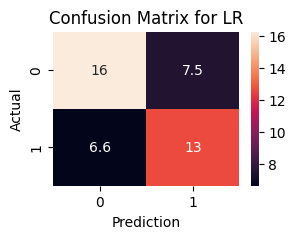

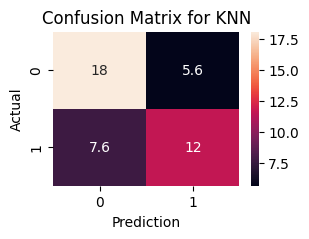

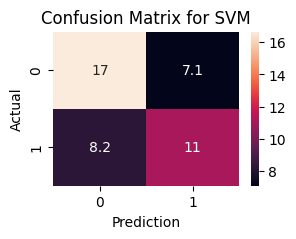

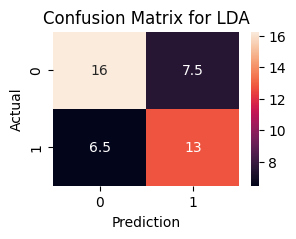

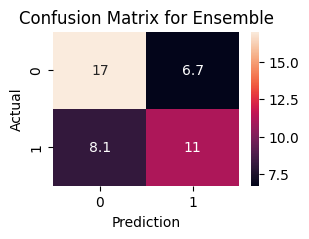

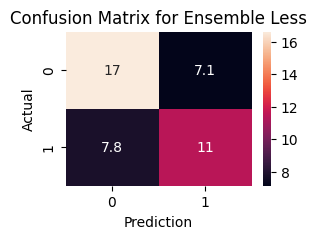

In [42]:
print_model_cfms(cfm_binary_scaled)

Extract descriptive statistics from the accuracies.

In [43]:
stats_binary_scaled = get_statistics(accs_binary_scaled)
results_binary_scaled = pd.DataFrame(stats_binary_scaled, 
                       index=['Mean', 'STD', 'Max', 'Min'], 
                       columns=['LR_binary_scaled', 'KNN_binary_scaled', 
                                'SVM_binary_scaled', 'LDA_binary_scaled',
                                'Ensemble_binary_scaled', 'Ensemble2_binary_norm'])

results_binary_scaled

,LR_binary_scaled,KNN_binary_scaled,SVM_binary_scaled,LDA_binary_scaled,Ensemble_binary_scaled,Ensemble2_binary_norm
Mean,0.671628,0.691395,0.644419,0.674419,0.654651,0.652558
STD,0.063627,0.061780,0.065637,0.061792,0.057661,0.057137
Max,0.813953,0.883721,0.790698,0.813953,0.790698,0.790698
Min,0.534884,0.534884,0.465116,0.534884,0.511628,0.488372


#### Cross-validation

Perform cross validation on this dataset with the four models from before. This is done to compare the results to the train-test split method.

In [44]:
perform_cross_validation(X_binary_scaled, y_binary_scaled)

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_sp

Model		CV Mean		CV std
{'LR': (0.596732026143791, 0.07913896498278652), 'KNN': (0.5915032679738561, 0.10996137170831338), 'SVM': (0.6143790849673203, 0.08179079848868318), 'LDA': (0.5908496732026143, 0.10405097381507136), 'Ensemble': (0.6320261437908496, 0.08875662978632372), 'Ensemble Less': (0.6261437908496732, 0.081413880360889)}


### Method Conclusion

The most accurate model for this method is SVM regression for both the train/test split and cross-validation. 

These models are not better than the baseline accuracies for either method.

## Normalized Binary Dataframe

This model will use a normalized version of the dataframe. 
This method will adjust the features to be normally distributed.

This should reduce some of the bias that results from the different scales in the dataframe's features

### Separate data

Make a copy of the original dataframe to ensure that it is preserved. 
Split the data into features and target.

In [45]:
df_pheno_binary_norm = df_pheno_binary.copy()

X_binary_norm = df_pheno_binary_norm.drop('DX', axis=1)
y_binary_norm = df_pheno_binary_norm['DX']

### Normalize columns

Normalize the features and update the feature dataframe to use these changes.

In [46]:
X_binary_norm = normalize_features(X_binary_norm)

### Evaluate Accuracy

Determine the accuracy of using this dataframe. 

#### 100-iteration Train/Test Split

Do 100-iterations of train/test splits using this dataframe. 
Generate 100 accuracies for the four models.

In [47]:
accs_binary_norm, cfm_binary_norm = get_accuracies(X_binary_norm, y_binary)

#### View Confusion Matrices

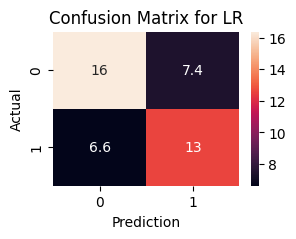

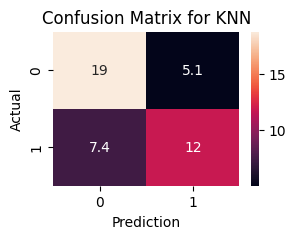

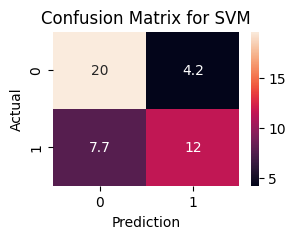

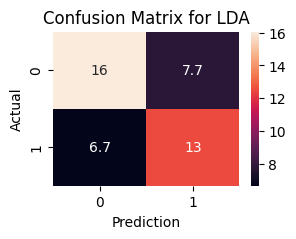

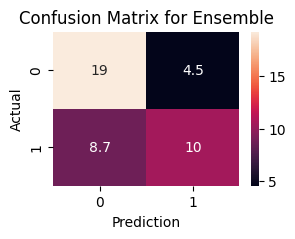

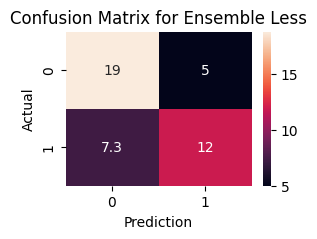

In [48]:
print_model_cfms(cfm_binary_norm)

Extract descriptive statistics from the accuracies.

In [49]:
stats_binary_norm = get_statistics(accs_binary_norm)
results_binary_norm = pd.DataFrame(stats_binary_norm, 
                       index=['Mean', 'STD', 'Max', 'Min'], 
                       columns=['LR_binary_norm', 'KNN_binary_norm', 
                                'SVM_binary_norm', 'LDA_binary_norm', 
                                'Ensemble_binary_norm', 'Ensemble2_binary_norm'])

results_binary_norm

,LR_binary_norm,KNN_binary_norm,SVM_binary_norm,LDA_binary_norm,Ensemble_binary_norm,Ensemble2_binary_norm
Mean,0.673256,0.710233,0.723023,0.664419,0.691628,0.714651
STD,0.059416,0.054482,0.069308,0.063880,0.065828,0.063250
Max,0.837209,0.837209,0.883721,0.837209,0.860465,0.883721
Min,0.488372,0.581395,0.488372,0.465116,0.488372,0.534884


#### Cross-validation

Perform cross validation on this dataset with the four models from before. This is done to compare the results to the train-test split method.

In [50]:
perform_cross_validation(X_binary_norm, y_binary_norm)

Model		CV Mean		CV std
{'LR': (0.6836601307189543, 0.13803698750429835), 'KNN': (0.7372549019607844, 0.09036642056316008), 'SVM': (0.7545751633986928, 0.1072219184326952), 'LDA': (0.654248366013072, 0.14621982892158555), 'Ensemble': (0.7016339869281045, 0.11620438979493182), 'Ensemble Less': (0.7428104575163399, 0.10211620883900313)}


### Method Conclusion

The most accurate model for this method is SVM regression for both the train/test split and cross-validation. 

The SVM model is more accurate than the binary classification baseline.

## Classification Conclusion

Generally, binary classification yielded more accurate results than the multi-class classification. 

The most accurate method for this classification method was SVM on the normalized dataframe.

--------------------------------------------------------------------------------------------------------------------------------

# Export Results

Create a single dataframe for all of the results from this notebook. 
Export them for safe keeping.

Combine the results to a single dataframe.

In [51]:
results_complete = pd.concat([results, results_scaled, results_norm, results_binary, results_binary_scaled, results_binary_norm], axis=1)
results_complete

,LR_multiclass,KNN_multiclass,SVM_multiclass,LDA_multiclass,Ensemble_multiclass,Ensemble2_multiclass,LR_multiclass_scaled,KNN_multiclass_scaled,SVM_multiclass_scaled,LDA_multiclass_scaled,...,SVM_binary_scaled,LDA_binary_scaled,Ensemble_binary_scaled,Ensemble2_binary_norm,LR_binary_norm,KNN_binary_norm,SVM_binary_norm,LDA_binary_norm,Ensemble_binary_norm,Ensemble2_binary_norm
Mean,0.563953,0.626977,0.532326,0.598372,0.588837,0.580000,0.621860,0.610930,0.617442,0.602791,...,0.644419,0.674419,0.654651,0.652558,0.673256,0.710233,0.723023,0.664419,0.691628,0.714651
STD,0.067752,0.056481,0.059826,0.061692,0.068190,0.067066,0.069115,0.066094,0.062087,0.074104,...,0.065637,0.061792,0.057661,0.057137,0.059416,0.054482,0.069308,0.063880,0.065828,0.063250
Max,0.767442,0.744186,0.674419,0.720930,0.720930,0.720930,0.837209,0.790698,0.790698,0.813953,...,0.790698,0.813953,0.790698,0.790698,0.837209,0.837209,0.883721,0.837209,0.860465,0.883721
Min,0.372093,0.441860,0.348837,0.395349,0.395349,0.395349,0.441860,0.441860,0.488372,0.418605,...,0.465116,0.534884,0.511628,0.488372,0.488372,0.581395,0.488372,0.465116,0.488372,0.534884


Save the complete results

In [52]:
results_complete.to_csv('Results\\2023.7.11-Pheno-Results.csv')